In [20]:
from utils import tokenize_with_hex_replacement
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, \
                            roc_curve, f1_score, \
                            precision_recall_curve, roc_curve, \
                            auc, precision_score, recall_score, \
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
import matplotlib.pyplot as plt

In [21]:
train = pd.read_parquet('data/train.parquet')
val = pd.read_parquet('data/val.parquet')
test = pd.read_parquet('data/test.parquet')

In [22]:
print('train duplicated', train.duplicated().sum())
print('val duplicated', val.duplicated().sum())
print('test duplicated', test.duplicated().sum())

train duplicated 0
val duplicated 0
test duplicated 0


In [23]:
train.opcode = train.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
val.opcode = val.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')
test.opcode = test.opcode.apply(lambda x : tokenize_with_hex_replacement(x) ).apply(lambda x : '\n'.join(x)).str.replace('0x', '')

In [24]:
trfrm = TfidfVectorizer(strip_accents='ascii', analyzer='word',lowercase=True, min_df = 5, ngram_range=(1,4))
X_train_tfidf = trfrm.fit_transform(train.opcode)
X_test_tfidf  = trfrm.transform(test.opcode)
X_val_tfidf  = trfrm.transform(val.opcode)

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train_tfidf, train.malicious)

LogisticRegression(random_state=42)

In [26]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [27]:
import pickle

with open('models_serialized/baseline.pkl', 'wb') as file:
    pickle.dump(model, file)

In [28]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC',  marker=".")
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [29]:
y_pred = model.predict_proba(X_val_tfidf)[:,-1]
y_val = val.malicious

In [30]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = -1  # for infinity

ix = np.argmax(fscore)
print(f'Best Threshold is {thresholds[ix]} with F-Score={fscore[ix]} on validation')
tr = thresholds[ix]

Best Threshold is 0.0015701337758086446 with F-Score=0.01705426356589147 on validation


/tmp/ipykernel_954594/4208855006.py:2: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


In [31]:
y_pred = model.predict_proba(X_test_tfidf)[:,-1]
y_pred_c = (y_pred > tr)
y_test = test.malicious

------------------------------------TESTING INFO-------------------------------------------------
Roc_Auc on test - 0.8610010953740773
F1 on test - 0.016700066800267203
precision on test - 0.008451656524678837
recall on test - 0.6944444444444444


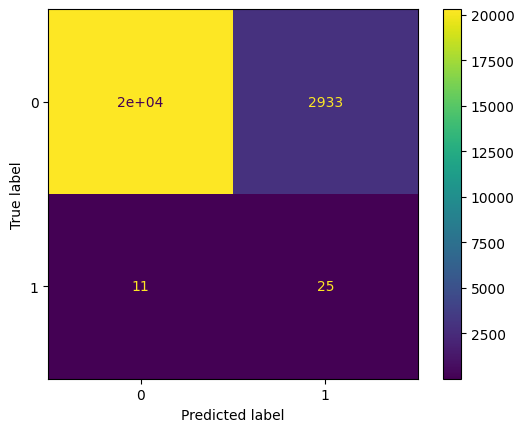

In [32]:
print('------------------------------------TESTING INFO-------------------------------------------------')
print(f'Roc_Auc on test - {roc_auc_score(y_test, y_pred)}')
print(f'F1 on test - {f1_score(y_test, y_pred_c)}')
print(f'precision on test - {precision_score(y_test, y_pred_c)}')
print(f'recall on test - {recall_score(y_test, y_pred_c)}')

cm = confusion_matrix(y_test, y_pred_c, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=model.classes_)
disp.plot()
plt.show()

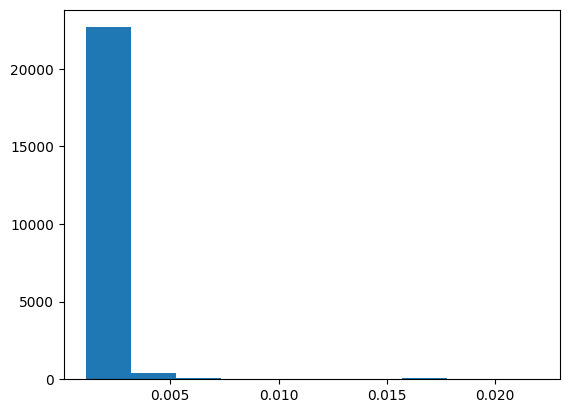

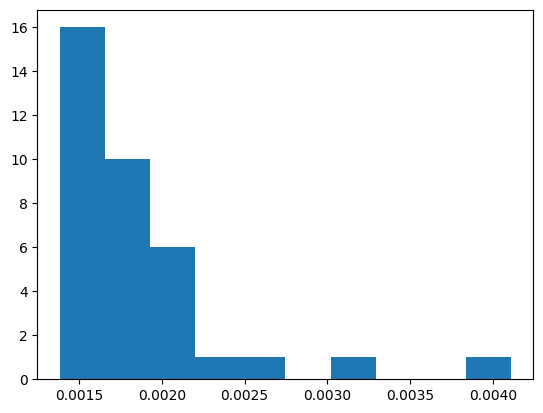

In [33]:
plt.hist(y_pred[y_test==0])
plt.show()
plt.hist(y_pred[y_test==1])
plt.show()